# Dataset Recommendation through DOC2VEC

## Objective: 

This notebook explores the feasibility of building a recommendation system for Kaggle Datasets and Users, leveraging the upvote behavior captured in the Meta Kaggle DatasetVotes dataset.

The primary goal is to investigate whether we can generate meaningful suggestions by analyzing user-dataset interactions. Specifically, the system aims to answer two types of recommendation prompts:

- People who liked this dataset also liked...
    - Recommending additional datasets based on the collective preferences of users who upvoted similar datasets.
- You might want to connect with this user...
    - Identifying users with similar interests, based on overlapping voting behavior, to encourage collaboration, learning, or networking.

These recommendations can help:

- Users discover new datasets tailored to their interests.
- Foster community engagement by highlighting like-minded individuals.

## Code

### Imports

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Faster data operations
import swifter

# Natural Language Processing
import nltk
from nltk.tokenize import word_tokenize

# Document embeddings
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim

# Visualization
import matplotlib.pyplot as plt

# Recommendation system utilities
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# Model utils
from sklearn.model_selection import train_test_split

# System and display
import warnings

### Config

In [2]:
warnings.filterwarnings('ignore')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/dhdzmota/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
### Constants
OOT_DATE = '2025-01-01'
RANDOM_SEED = 42
VOTES_THRESHOLD = 5
COMPARISON_THRESHOLD = 0.75

### Read data 

In [4]:
# Load core datasets
df_datasets = pd.read_csv('../data/archive/Datasets.csv')
df_dataset_votes = pd.read_csv('../data/archive/DatasetVotes.csv')
df_dataset_versions = pd.read_csv('../data/archive/DatasetVersions.csv')

### Functions

In [5]:
def create_user_dataset_relation(df_versions: pd.DataFrame, df_votes: pd.DataFrame) -> pd.DataFrame:
    """
    Create a user-dataset relationship DataFrame by merging DatasetVersions and DatasetVotes.

    Parameters:
    - df_versions (pd.DataFrame): The DatasetVersions DataFrame.
    - df_votes (pd.DataFrame): The DatasetVotes DataFrame.

    Returns:
    - pd.DataFrame: A DataFrame containing DatasetId, CreationDate, UserId, and VoteDate.
    """
    # Rename for clarity and merge
    user_dataset_relation = df_versions.rename(
        columns={'Id': 'DatasetVersionId'}
    )[['DatasetVersionId', 'DatasetId', 'CreationDate']].merge(
        df_votes[['DatasetVersionId', 'UserId', 'VoteDate']],
        on='DatasetVersionId',
        how='right'
    ).drop('DatasetVersionId', axis=1)
    return user_dataset_relation

def create_simplified_dataset(df_datasets: pd.DataFrame, verbose: bool = False) -> pd.DataFrame:
    """
    Create a simplified dataset-user mapping by combining CreatorUserId and OwnerUserId.

    Parameters:
    - df_datasets (pd.DataFrame): The Datasets DataFrame from Meta Kaggle.
    - verbose (bool): Whether to print info about the output DataFrame.

    Returns:
    - pd.DataFrame: A DataFrame with columns ['DatasetId', 'UserId'].
    """
    # Select and rename relevant columns
    simplified = df_datasets[['CreatorUserId', 'OwnerUserId', 'Id']].rename(columns={'Id': 'DatasetId'})
    
    # Combine user fields into a list and explode
    simplified['UserId'] = simplified[['CreatorUserId', 'OwnerUserId']].values.tolist()
    simplified = simplified[['DatasetId', 'UserId']].explode('UserId').dropna()

    # Cast types and drop duplicates
    simplified = simplified.astype({'DatasetId': int, 'UserId': int}).drop_duplicates()
    if verbose:
        print(f"Simplified dataset created. Shape: {simplified.shape}")

    return simplified

def add_user_dataset_identifier(df: pd.DataFrame,
                                dataset_col: str = 'DatasetId',
                                user_col: str = 'UserId',
                                inplace: bool = False) -> pd.DataFrame:
    """
    Adds a combined identifier column (e.g., 'UserId_DatasetId') to a DataFrame.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - dataset_col (str): Name of the dataset ID column. Default is 'DatasetId'.
    - user_col (str): Name of the user ID column. Default is 'UserId'.
    - inplace (bool): Whether to modify the original DataFrame in place.

    Returns:
    - pd.DataFrame: DataFrame with the new identifier column.
    """
    if not inplace:
        df = df.copy()
    new_col = f'{user_col}_{dataset_col}'
    df[new_col] = df[dataset_col].astype(str) + '_' + df[user_col].astype(str)

    return df

def remove_autolikes(user_dataset_df: pd.DataFrame,
                     simplified_dataset_df: pd.DataFrame,
                     id_col: str = 'UserId_DatasetId') -> pd.DataFrame:
    """
    Removes autolikes from the user-dataset interaction DataFrame.
    Autolikes are defined as likes made by the dataset's creator or owner.

    Parameters:
    - user_dataset_df (pd.DataFrame): DataFrame with user-dataset interactions.
    - simplified_dataset_df (pd.DataFrame): DataFrame containing known autolikes based on ownership.
    - id_col (str): Column used to identify user-dataset pairs (default: 'UserId_DatasetId').

    Returns:
    - pd.DataFrame: Filtered DataFrame without autolikes.
    """
    # Ensure copy to avoid modifying original data
    filtered_df = user_dataset_df[~user_dataset_df[id_col].isin(simplified_dataset_df[id_col])].copy()
    
    return filtered_df


def convert_date_to_datetime(df: pd.DataFrame, column: str = 'CreationDate',) -> pd.DataFrame:
    """
    Converts the specified column in a DataFrame to datetime format.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column (str): The name of the column to convert. Default is 'CreationDate'.

    Returns:
    - pd.DataFrame: DataFrame with the converted datetime column.
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    df[column] = pd.to_datetime(df[column], errors='coerce')
    return df

def split_user_dataset_by_date(df: pd.DataFrame,
                                date_col: str = 'CreationDate',
                                oot_date: str = '2025-01-01',
                                verbose: bool = True) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Splits a user-dataset interaction DataFrame into training and OOT sets based on a given date.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the date column.
    - date_col (str): The column name to use for the date filter (default: 'CreationDate').
    - oot_date (str): The out-of-time cutoff date (YYYY-MM-DD format or similar).
    - verbose (bool): Whether to print information about the split.

    Returns:
    - Tuple[pd.DataFrame, pd.DataFrame]: (training_set, oot_set)
    """
    oot_datetime = pd.to_datetime(oot_date)

    df_oot = df[df[date_col] >= oot_datetime].copy()
    df_train = df[df[date_col] < oot_datetime].copy()

    if verbose:
        print(f"Split complete using OOT date: {oot_datetime.date()}")
        print(f"📦 Training set: {df_train.shape[0]} rows")
        print(f"📦 OOT set: {df_oot.shape[0]} rows")

    return df_train, df_oot

def plotting_votes(df: pd.DataFrame,
                      date_col: str = 'VoteDate',
                      title: str = 'Monthly Vote Activity',
                      color: str = 'darkred',
                      alpha: str = 1, 
                      periodicity='M',
                      figsize: tuple = (12, 5),
                  ) -> None:
    """
    Plots the number of rows per month using the specified date column
    to help visually identify outliers or trends.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - date_col (str): The column with datetime values (default: 'VoteDate').
    - title (str): Plot title.
    - color (str): Line color for the plot.
    - figsize (tuple): Size of the figure.
    """
    # Group by month and plot
    grouper = pd.Grouper(key=date_col, freq=periodicity)
    monthly_counts = df.groupby(grouper).size()

    plt.figure(figsize=figsize)
    monthly_counts.plot(color=color, alpha=alpha)
    plt.title(title)
    plt.xlabel(f'Month ({date_col})')
    plt.ylabel('Number of Votes')
    plt.grid(True)
    plt.tight_layout()

def filter_users_by_vote_threshold(df: pd.DataFrame,
                                   user_col: str = 'UserId',
                                   threshold: int = 5,
                                   verbose: bool = True) -> pd.Index:
    """
    Returns user IDs that appear at least 'threshold' times in the DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing user interactions.
    - user_col (str): Name of the column with user IDs.
    - threshold (int): Minimum number of votes required to keep the user.
    - verbose (bool): Whether to print the number of users retained.

    Returns:
    - pd.Index: Index of user IDs that meet or exceed the threshold.
    """
    vote_counts = df[user_col].value_counts()
    usable_users = vote_counts[vote_counts >= threshold].index

    if verbose:
        print(f"{len(usable_users)} users retained with ≥ {threshold} votes.")

    return usable_users


def split_users(user_ids: pd.Index,
                train_size: float = 0.8,
                test_size: float = 0.6,
                random_state: int = 42,
                verbose: bool = True) -> [pd.Index, pd.Index, pd.Index]:
    """
    Splits a list or index of user IDs into train, test, and validation subsets.

    Parameters:
    - user_ids (pd.Index or list): User IDs to split.
    - train_size (float): Proportion of users for the training set (default: 0.8).
    - test_size (float): Proportion of remaining users assigned to the test set (default: 0.6).
    - random_state (int): Random seed for reproducibility.
    - verbose (bool): Whether to print the size of each split.

    Returns:
    - Tuple of pd.Index: (train_users, test_users, val_users)
    """
    # First split: train vs rest
    train_users, rest_users = train_test_split(user_ids, train_size=train_size, random_state=random_state)
    
    # Second split: test vs validation from rest
    test_users, val_users = train_test_split(rest_users, train_size=test_size, random_state=random_state)

    if verbose:
        print(f"User split complete:")
        print(f"   • Train users: {len(train_users)}")
        print(f"   • Test users: {len(test_users)}")
        print(f"   • Validation users: {len(val_users)}")

    return train_users, test_users, val_users

def treatment_function(user_dataset_relation_df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates rolling lists of datasets voted on by users in chronological order.

    This function is designed to generate N-sequence patterns of dataset interactions,
    which can be useful for sequence-based recommendation models.

    Steps:
    1. Sorts the input DataFrame by 'VoteDate'.
    2. For each row, creates a list of the current DatasetId and the N previous ones.
    3. Filters out rows where any of the three dataset IDs are missing (represented by 0).
    4. Returns a simplified DataFrame with the vote timestamp and the triplet of dataset IDs.

    Parameters:
    - user_dataset_relation_df (pd.DataFrame): DataFrame with at least 'VoteDate' and 'DatasetId' columns.

    Returns:
    - pd.DataFrame: A DataFrame with columns:
        • 'VoteDate': Timestamp of the current vote.
        • 'dataset_id': List containing [..., DatasetId_t-2, DatasetId_t-1, DatasetId_t]
          where t is the current row, representing a rolling interaction window.
    """
    # Step 1: Sort by vote timestamp
    sorted_df = user_dataset_relation_df.sort_values('VoteDate')

    # Step 2: Create rolling dataset triplets
    dataset_ids_threshold = []
    for nb_count in range(VOTES_THRESHOLD-1):
        col = f'DatasetId{nb_count+1}'
        dataset_ids_threshold.append(col)
        sorted_df[col] = sorted_df['DatasetId'].shift(nb_count+1).fillna(0).astype(int)
    sorted_df['dataset_id'] = sorted_df[['DatasetId'] + dataset_ids_threshold].values.tolist()

    # Step 3: Remove triplets that contain a placeholder (0) from padding
    filtered_df = sorted_df[~sorted_df['dataset_id'].apply(lambda x: 0 in x)]

    # Step 4: Keep only the necessary columns
    final_df = filtered_df[['VoteDate', 'dataset_id']]

    return final_df

### Process data

In [6]:
user_dataset_relation = create_user_dataset_relation(
    df_versions=df_dataset_versions, df_votes=df_dataset_votes
)

In [7]:
simplified_dataset = create_simplified_dataset(df_datasets, verbose=True)

Simplified dataset created. Shape: (489863, 2)


In [8]:
simplified_dataset = add_user_dataset_identifier(simplified_dataset)
user_dataset_relation = add_user_dataset_identifier(user_dataset_relation)

In [9]:
user_dataset_relation = remove_autolikes(user_dataset_relation, simplified_dataset)

In [10]:
user_dataset_relation = convert_date_to_datetime(user_dataset_relation, column='CreationDate')
user_dataset_relation = convert_date_to_datetime(user_dataset_relation, column='VoteDate')

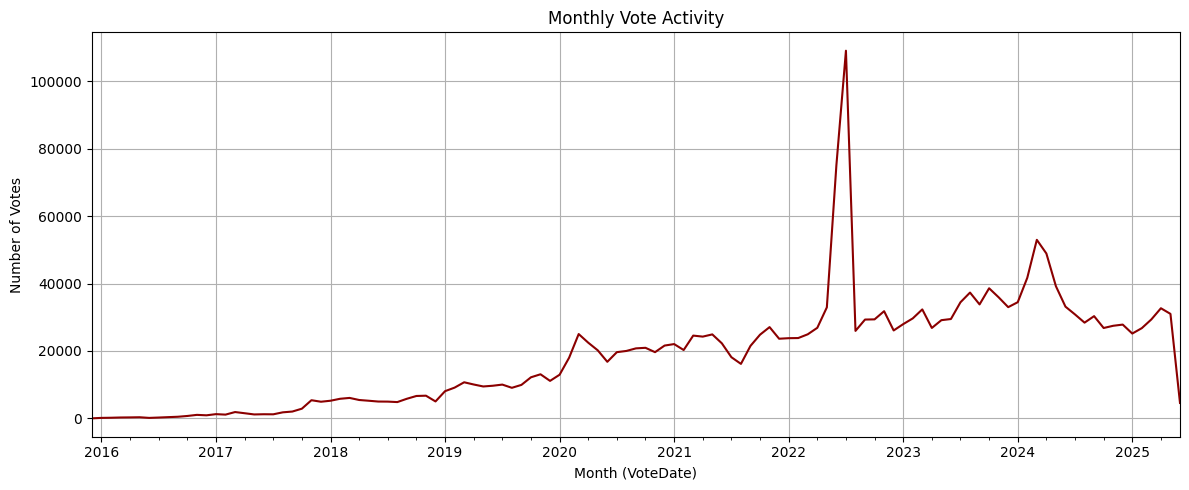

In [11]:
plotting_votes(user_dataset_relation)

In [15]:
user_votes_speed = user_dataset_relation.groupby('UserId').agg(
    vote_date_max=('VoteDate', 'max'),
    vote_date_min=('VoteDate', 'min'),
    vote_count=('VoteDate', 'count')
)
count_of_votes = user_dataset_relation.UserId.value_counts()
speed_of_votes = (user_votes_speed.vote_count/((user_votes_speed.vote_date_max-user_votes_speed.vote_date_min).dt.days+1)).sort_values(ascending=False)

In [62]:
# Based on the intersection speed of the votes and the amount of votes given a quantile, outliers were taken out. 
quantile = 0.99975
outliers = speed_of_votes.loc[
    list(
        set(count_of_votes[count_of_votes>count_of_votes.quantile(quantile)].index).intersection(
            set(speed_of_votes[speed_of_votes>speed_of_votes.quantile(quantile)].index)
        )
    )
].index

In [63]:
# Finding outliers:
user_dataset_relation_outlier = user_dataset_relation[(user_dataset_relation.UserId.isin(outliers))]
user_dataset_relation = user_dataset_relation[~(user_dataset_relation.UserId.isin(outliers))]

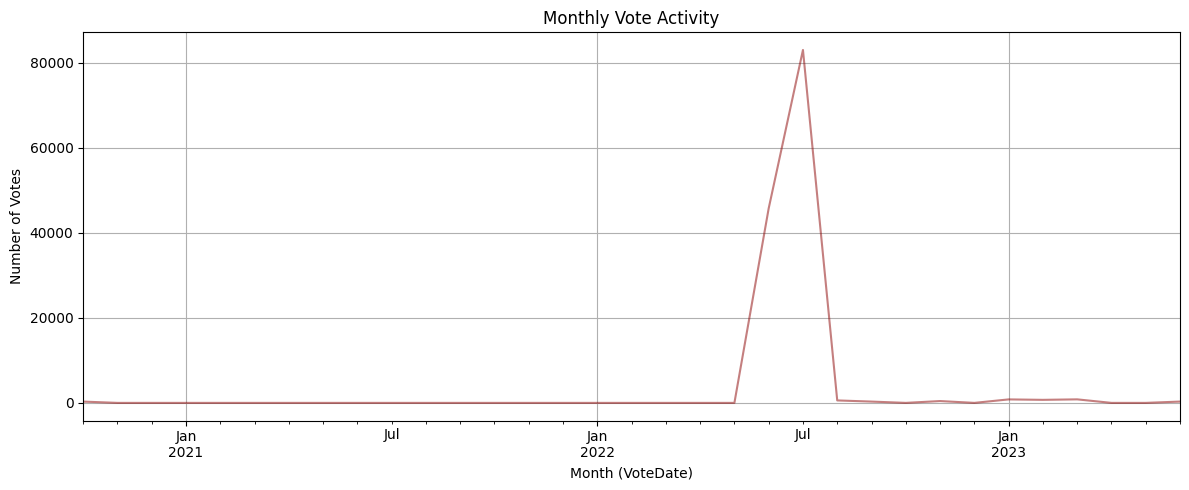

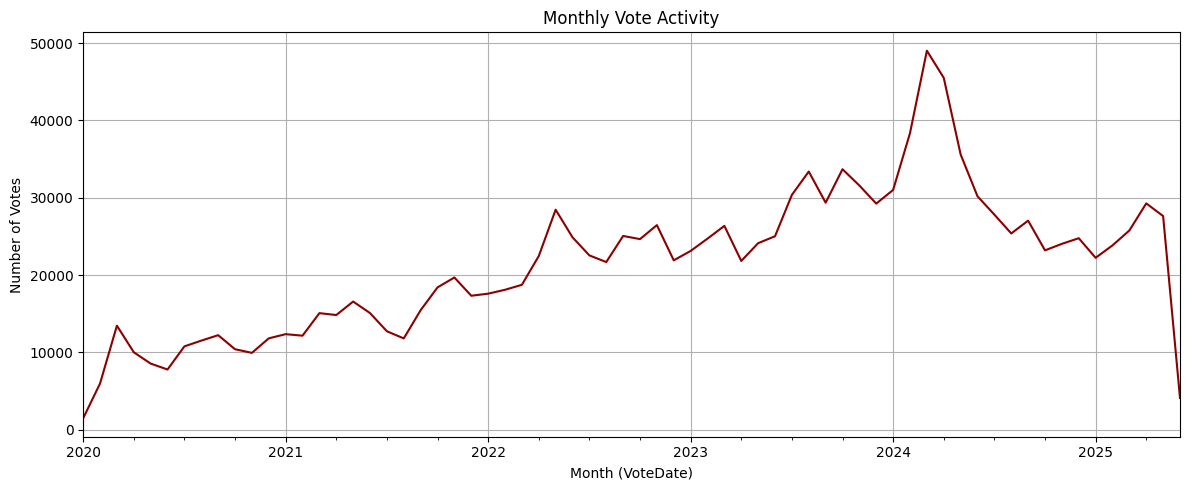

In [69]:
plotting_votes(user_dataset_relation_outlier, alpha=0.5, periodicity='M')
plotting_votes(user_dataset_relation, alpha=1)

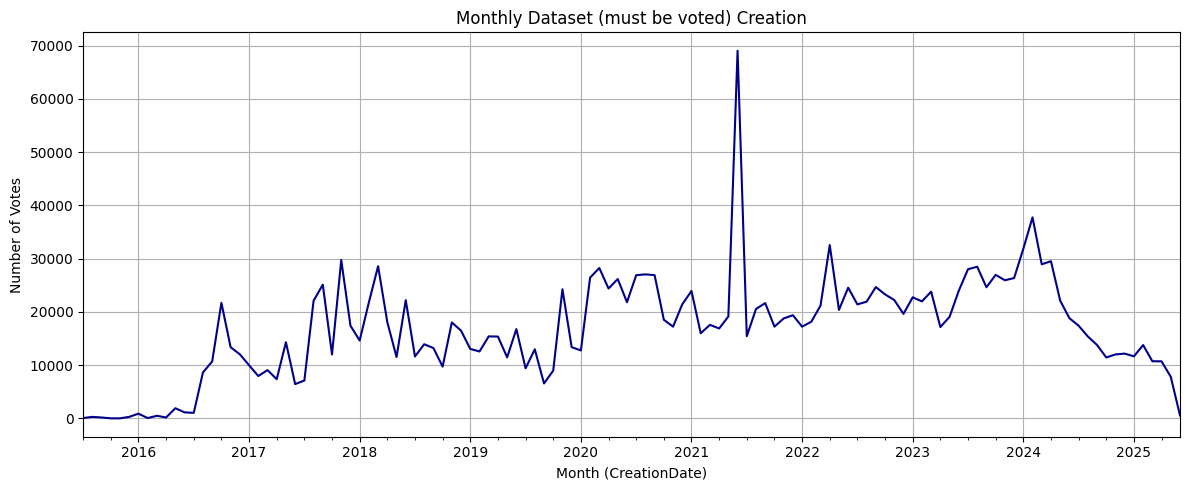

In [65]:
plotting_votes(user_dataset_relation, date_col='CreationDate', color='darkblue', title='Monthly Dataset (must be voted) Creation')

In [66]:
# To maintain consistency with recent data, we are keeping only records (of datasets) created from 2020 onward.
user_dataset_relation = user_dataset_relation[user_dataset_relation.CreationDate >= pd.to_datetime('2020-01-01')]

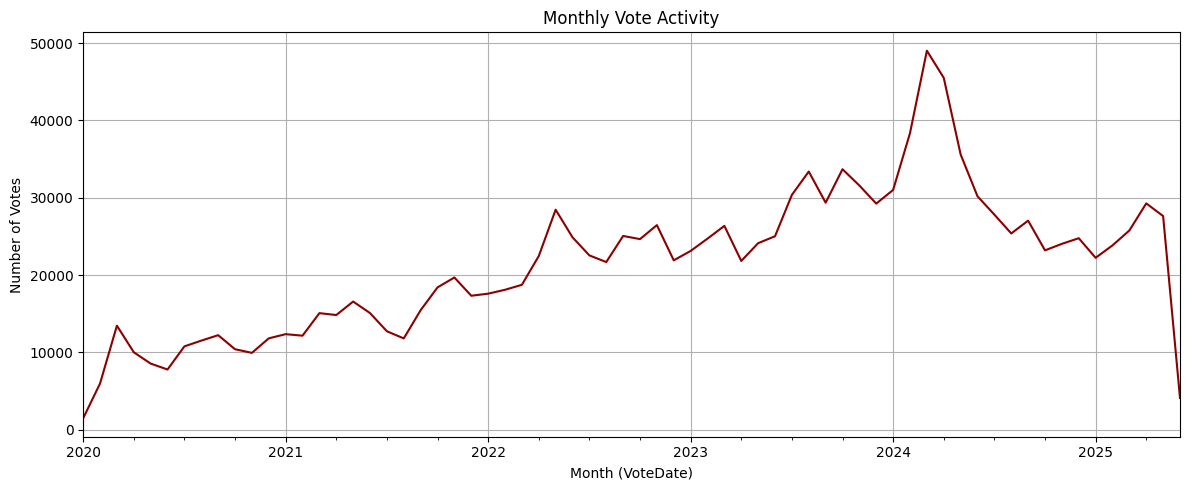

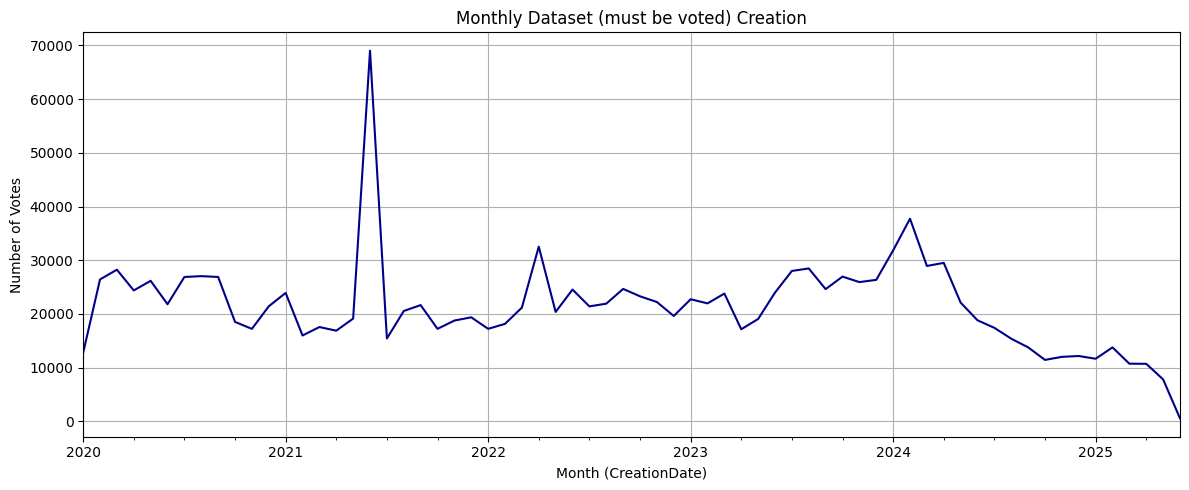

In [67]:
plotting_votes(user_dataset_relation)
plotting_votes(user_dataset_relation, date_col='CreationDate', color='darkblue', title='Monthly Dataset (must be voted) Creation')

In [70]:
# Lets get a inintial treatment of the dataset versions
df_dataset_versions['TotalDescription'] = (
    df_dataset_versions.Title.fillna('') + ' ' + 
    df_dataset_versions.Subtitle.fillna('') + ' ' +
    df_dataset_versions.Description.fillna('') 
)

### Data splitting

In [71]:
user_dataset_relation_t, user_dataset_relation_oot = split_user_dataset_by_date(
    user_dataset_relation, oot_date=OOT_DATE
)

Split complete using OOT date: 2025-01-01
📦 Training set: 1359910 rows
📦 OOT set: 55163 rows


In [72]:
# We apply the votes threshold for each users.
actual_usable_users = filter_users_by_vote_threshold(
    user_dataset_relation_t, threshold=3
)

actual_usable_users_oot = filter_users_by_vote_threshold(
    user_dataset_relation_oot, threshold=3
)

49626 users retained with ≥ 3 votes.
2143 users retained with ≥ 3 votes.


In [73]:
train_users, test_users, val_users = split_users(actual_usable_users, random_state=RANDOM_SEED)

User split complete:
   • Train users: 39700
   • Test users: 5955
   • Validation users: 3971


In [74]:
# Current datasets
user_dataset_relation_t__train = user_dataset_relation_t[user_dataset_relation_t.UserId.isin(train_users)]
user_dataset_relation_t__test = user_dataset_relation_t[user_dataset_relation_t.UserId.isin(test_users)]
user_dataset_relation_t__val = user_dataset_relation_t[user_dataset_relation_t.UserId.isin(val_users)]

# Future datsets
user_dataset_relation_oot__train = user_dataset_relation_oot[user_dataset_relation_oot.UserId.isin(train_users)]
user_dataset_relation_oot__test = user_dataset_relation_oot[~user_dataset_relation_oot.UserId.isin(train_users)]


In [75]:
agg__user_dataset_relation_t__train = user_dataset_relation_t__train.groupby('UserId').apply(treatment_function)
agg__user_dataset_relation_t__test = user_dataset_relation_t__test.groupby('UserId').apply(treatment_function)
agg__user_dataset_relation_t__val = user_dataset_relation_t__val.groupby('UserId').apply(treatment_function)
agg__user_dataset_relation_oot__train = user_dataset_relation_oot__train.groupby('UserId').apply(treatment_function)
agg__user_dataset_relation_oot__test = user_dataset_relation_oot__test.groupby('UserId').apply(treatment_function)

In [76]:
#agg__user_dataset_relation_t__train#, agg__user_dataset_relation_t__test, agg__user_dataset_relation_t__val

In [77]:
all_train_dataset_ids = agg__user_dataset_relation_t__train.reset_index().drop('level_1', axis=1).explode('dataset_id').dataset_id.unique()
all_test_dataset_ids = agg__user_dataset_relation_t__test.reset_index().drop('level_1', axis=1).explode('dataset_id').dataset_id.unique()
all_val_dataset_ids = agg__user_dataset_relation_t__val.reset_index().drop('level_1', axis=1).explode('dataset_id').dataset_id.unique()

In [78]:
# These might appear in the training set
all_train_datasets = df_dataset_versions[df_dataset_versions.DatasetId.isin(all_train_dataset_ids)].sort_values('VersionNumber').groupby('DatasetId').Description.last()
# This is just for training the doc2vec model without duplicates
all_train_datasets_unique = all_train_datasets.drop_duplicates().dropna()

In [79]:
all_test_datasets = df_dataset_versions[df_dataset_versions.DatasetId.isin(all_test_dataset_ids)].sort_values('VersionNumber').groupby('DatasetId').Description.last()
all_test_datasets_unique = all_test_datasets.drop_duplicates().dropna()

all_val_datasets = df_dataset_versions[df_dataset_versions.DatasetId.isin(all_val_dataset_ids)].sort_values('VersionNumber').groupby('DatasetId').Description.last()
all_val_datasets_unique = all_val_datasets.drop_duplicates().dropna()

### Training a Doc2VecModel

In [80]:
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(all_train_datasets_unique)]

In [81]:
model = Doc2Vec(vector_size=128, min_count=8, epochs=50)
model.random.seed(RANDOM_SEED)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [82]:
def infer_vector_from_doc(doc, model=None):
    if model is not None:
        inference = model.infer_vector(word_tokenize(doc.lower()))
        return inference
    return None

In [83]:
all_train_datasets_embeddings = all_train_datasets.fillna('No description available.').swifter.apply(infer_vector_from_doc, model=model)

Pandas Apply:   0%|          | 0/77175 [00:00<?, ?it/s]

In [84]:
all_test_datasets_embeddings = all_test_datasets.fillna('No description available.').swifter.apply(infer_vector_from_doc, model=model)

Pandas Apply:   0%|          | 0/36711 [00:00<?, ?it/s]

In [85]:
all_val_datasets_embeddings = all_val_datasets.fillna('No description available.').swifter.apply(infer_vector_from_doc, model=model)

Pandas Apply:   0%|          | 0/26754 [00:00<?, ?it/s]

In [86]:
agg__user_dataset_relation_w_embeddings_t__train = agg__user_dataset_relation_t__train.dataset_id.explode().reset_index().merge(
    all_train_datasets_embeddings.apply(lambda x: x/np.linalg.norm(x)).reset_index(), 
    left_on='dataset_id',
    right_on='DatasetId', 
    how='left',
).groupby(['UserId','level_1']).Description.mean()

In [87]:
agg__user_dataset_relation_w_embeddings_t__test = agg__user_dataset_relation_t__test.dataset_id.explode().reset_index().merge(
    all_test_datasets_embeddings.apply(lambda x: x/np.linalg.norm(x)).reset_index(), 
    left_on='dataset_id',
    right_on='DatasetId', 
    how='left',
).groupby(['UserId','level_1']).Description.mean()

In [88]:
agg__user_dataset_relation_w_embeddings_t__val = agg__user_dataset_relation_t__val.dataset_id.explode().reset_index().merge(
    all_val_datasets_embeddings.apply(lambda x: x/np.linalg.norm(x)).reset_index(), 
    left_on='dataset_id',
    right_on='DatasetId', 
    how='left',
).groupby(['UserId','level_1']).Description.mean()

In [89]:
agg__user_dataset_relation_t__train['embeddings'] = agg__user_dataset_relation_w_embeddings_t__train.apply(lambda x: x/np.linalg.norm(x))

In [90]:
agg__user_dataset_relation_t__test['embeddings'] = agg__user_dataset_relation_w_embeddings_t__test.apply(lambda x: x/np.linalg.norm(x))

In [91]:
agg__user_dataset_relation_t__val['embeddings'] = agg__user_dataset_relation_w_embeddings_t__val.apply(lambda x: x/np.linalg.norm(x))

In [92]:
# Manually check if recommendations work:

In [93]:
agg__user_dataset_relation_oot__test.sample(1)

,,VoteDate,dataset_id
UserId,,,
24662298,2198013,2025-04-14,"[6929344, 7135941, 6929617, 6896475, 6874872]"


In [94]:
# Step 1: select a random sample from any set, in this case validation
random_sample = agg__user_dataset_relation_t__val.sample(1)

# Step 2: if its the same set, remove the user from the set so comparisons are not made for the same user.
try:
    new_agg__user_dataset_relation_t__val = agg__user_dataset_relation_t__val.drop(random_sample.index[0])
except:
    pass
new_agg__user_dataset_relation_t__val

# Step 3: Make a comparison of all the embeddings with the random sampled embedding
embedding_comparison = new_agg__user_dataset_relation_t__val.embeddings.swifter.apply(
    lambda x: (x* random_sample.iloc[0].embeddings).sum()
).sort_values()

# Compare and contrast
random_sample_list = agg__user_dataset_relation_t__val.loc[random_sample.head(1).index]
random_sample_list = random_sample_list.dataset_id.iloc[0]

comparison_sample_list_worst = agg__user_dataset_relation_t__val.loc[embedding_comparison[embedding_comparison > COMPARISON_THRESHOLD].head(1).index]
comparison_sample_list_best = agg__user_dataset_relation_t__val.loc[embedding_comparison[embedding_comparison > COMPARISON_THRESHOLD].tail(1).index]

comparison_sample_list_worst = comparison_sample_list_worst.dataset_id.iloc[0]
comparison_sample_list_best = comparison_sample_list_best.dataset_id.iloc[0]

Pandas Apply:   0%|          | 0/40917 [00:00<?, ?it/s]

In [95]:
intersection_worst = set(comparison_sample_list_worst).intersection(random_sample_list)
intersection_best = set(comparison_sample_list_best).intersection(random_sample_list)

In [96]:
print(set(comparison_sample_list_worst).symmetric_difference(random_sample_list))
print(set(comparison_sample_list_best).symmetric_difference(random_sample_list))

{1966753, 1984959, 136082, 1981846, 1984957, 1980671}
{136082, 1984959}


In [97]:
set(comparison_sample_list_best).symmetric_difference(random_sample_list)

{136082, 1984959}

In [98]:
df_dataset_versions[
    df_dataset_versions.DatasetId.isin(intersection_worst)
].sort_values(
    'VersionNumber'
).drop_duplicates(
    'DatasetId', keep='last'
).set_index(
    'DatasetId'
)[['Title', 'Slug', 'Subtitle', 'Description']]

,Title,Slug,Subtitle,Description
DatasetId,,,,
1914663,5 flavors of bert nbme,5-flavors-bert,NaN,fold0 bert-base-cased\nfold1 albert-base-v2\nf...
1984917,UltraMNIST-224x224,ultramnist224x224,Reduced Image resolution for the UltraMNIST co...,Reduced Image resolution for the UltraMNIST co...


In [99]:
df_dataset_versions[
    df_dataset_versions.DatasetId.isin(comparison_sample_list_worst)
].sort_values(
    'VersionNumber'
).drop_duplicates(
    'DatasetId', keep='last'
).set_index(
    'DatasetId'
)[['Title', 'Slug', 'Subtitle', 'Description']].drop(intersection_worst)

,Title,Slug,Subtitle,Description
DatasetId,,,,
1981846,NANO-EUR Stock Market @Kraken,nanoeur-stock-market-kraken,NANO-EUR stock market at Kraken Exchange,### Context\n\nReal and up to date stock marke...
1984959,UltraMNIST-512x512,ultramnist512x512,Reduced Image resolution for the UltraMNIST co...,educed Image resolution for the UltraMNIST com...
1984957,UltraMNIST-1024x1024,ultramnist1024x1024,Reduced Image resolution for the UltraMNIST co...,Reduced Image resolution for the UltraMNIST co...


In [100]:
df_dataset_versions[
    df_dataset_versions.DatasetId.isin(random_sample_list)
].sort_values(
    'VersionNumber'
).drop_duplicates(
    'DatasetId', keep='last'
).set_index(
    'DatasetId'
)[['Title', 'Slug', 'Subtitle', 'Description']].drop(intersection_worst)

,Title,Slug,Subtitle,Description
DatasetId,,,,
1966753,AP Exam Curve Data 2022,ap-exam-curve-data-2022,This data demonstrates the points they need to...,### Context\n\nI am an aspiring Freshman in a ...
1980671,HappyWhale species taxonomy,happywhalespeciesclassification,Classification of species found in the happywh...,### Inspiration\n\nFor the [HappyWhale competi...
136082,Earthquake,earthquake,Know about earthquakes just after they happen,### Context\n\nThis data set is taken from USG...


In [101]:
df_dataset_versions[
    df_dataset_versions.DatasetId.isin(comparison_sample_list_best)
].sort_values(
    'VersionNumber'
).drop_duplicates(
    'DatasetId', keep='last'
).set_index(
    'DatasetId'
)[['Title', 'Slug', 'Subtitle', 'Description']].drop(intersection_best)

,Title,Slug,Subtitle,Description
DatasetId,,,,
1984959,UltraMNIST-512x512,ultramnist512x512,Reduced Image resolution for the UltraMNIST co...,educed Image resolution for the UltraMNIST com...


In [102]:
df_dataset_versions[
    df_dataset_versions.DatasetId.isin(random_sample_list)
].sort_values(
    'VersionNumber'
).drop_duplicates(
    'DatasetId', keep='last'
).set_index(
    'DatasetId'
)[['Title', 'Slug', 'Subtitle', 'Description']].drop(intersection_best)

,Title,Slug,Subtitle,Description
DatasetId,,,,
136082,Earthquake,earthquake,Know about earthquakes just after they happen,### Context\n\nThis data set is taken from USG...


In [358]:
# Lets test a generic user now...
user_dataset_relation

,DatasetId,CreationDate,UserId,VoteDate,UserId_DatasetId
17125,58,2020-03-01 09:04:29,3218149,2020-03-05,58_3218149
17126,58,2020-04-28 05:27:16,3608062,2020-05-04,58_3608062
17127,58,2020-04-28 05:27:16,4174380,2020-05-01,58_4174380
17128,58,2020-03-27 15:19:09,4727025,2020-04-21,58_4727025
17129,58,2020-08-23 07:50:43,3948536,2020-08-25,58_3948536
...,...,...,...,...,...
2213071,7544631,2025-05-29 10:27:57,27026046,2025-05-29,7544631_27026046
2213072,7545346,2025-05-29 11:56:22,26985119,2025-06-01,7545346_26985119
2213074,7566127,2025-06-01 12:39:16,26744881,2025-06-01,7566127_26744881
2213075,7566127,2025-06-01 12:39:16,4512670,2025-06-01,7566127_4512670


In [359]:
# Given a list of 5 datasets. We need to compute the corresponding embeddings. 
last_version_datasets_resumed = df_dataset_versions[df_dataset_versions.DatasetId.isin(user_dataset_relation.DatasetId.unique())].sort_values(
    'VersionNumber'
).drop_duplicates(
    'DatasetId', keep='last'
).set_index(
    'DatasetId'
)[['Title', 'Slug', 'Subtitle', 'Description']].sample(5)

In [360]:
last_version_datasets_resumed

,Title,Slug,Subtitle,Description
DatasetId,,,,
2651583,Fiscal_measures_to_Covid-19,fiscalmeasurestocovid-19,Fiscal measures in response to Covid-19,This database is a personally edited version o...
3918795,PGA Tournaments with Weather Data (2009-2022),pga-tournament-data-with-weather-data-2009-2022,NaN,This data set was built using the PGA Tour His...
6441580,Prediction of Atherosclerosis Heart Diseases,prediction-of-atherosclerosis-heart-diseases,NaN,NaN
2840264,Used car price dataset,used-car-price-dataset,"Dataset for car price prediction, and analysis...",**Context**\nThis dataset contains information...
3235094,US_5year_bind_yield1962-2023,us-5year-bind-yield1962-2023,NaN,NaN


Tenemos un usuario, dicho usuario tiene distintos "likes" a datasets, se contempla el like actual, y además los dos últimos. Independientemente de la fecha. 

En este caso, serían 5 datasets (documentos), que se concatenan y se hace un documento, el cuál se convierte en embedding doc2vec. Una vez se tenga esta información, se procede a tener usuario (con ciertas características), embeddings. 

In [69]:
#!uv pip install torch

In [ ]:
# We need to remove autovotes (if they exist):
# Autovotes are defined as giving upvote to a dataset uploaded by yourself.
